In [1]:
#Loading Modules

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.utils import shuffle
from google.colab import files
from IPython.display import Image
import cv2
from PIL import Image
import os
import tensorflow as tf
import tensorflow .keras as keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
#Extracting Data

train_data ="/content/train.zip"
test_data = "/content/test.zip"

with ZipFile(train_data, 'r') as zip:
  zip.extractall()
  print('done')
with ZipFile(test_data, 'r') as zip:
  zip.extractall()
  print('done')

done
done


In [3]:
#Setup image generators

base_path="/content/"

image_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.2, horizontal_flip=True)

train_generator = image_datagen.flow_from_directory(base_path + "train", 
                                                    target_size=(300,300),
                                                    subset='training',
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = image_datagen.flow_from_directory(base_path + "train", 
                                                    target_size=(300,300),
                                                    subset='validation',
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 354 images belonging to 4 classes.
Found 86 images belonging to 4 classes.


In [4]:
#Creating model

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(300,300,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
#Training model

trained = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.n//validation_generator.batch_size
                              )

Epoch 1/10
11/11 [==============================] - 114s 10s/step - loss: 317.8506 - accuracy: 0.4348 - val_loss: 26.2737 - val_accuracy: 0.2656
Epoch 2/10
11/11 [==============================] - 111s 10s/step - loss: 54.1999 - accuracy: 0.7050 - val_loss: 39.3864 - val_accuracy: 0.4074
Epoch 3/10
11/11 [==============================] - 110s 10s/step - loss: 22.5656 - accuracy: 0.8602 - val_loss: 32.5775 - val_accuracy: 0.4259
Epoch 4/10
11/11 [==============================] - 115s 10s/step - loss: 9.3792 - accuracy: 0.8977 - val_loss: 22.4012 - val_accuracy: 0.4531
Epoch 5/10
11/11 [==============================] - 111s 10s/step - loss: 2.1241 - accuracy: 0.9689 - val_loss: 33.3022 - val_accuracy: 0.3519
Epoch 6/10
11/11 [==============================] - 104s 9s/step - loss: 1.8487 - accuracy: 0.9760 - val_loss: 21.3077 - val_accuracy: 0.4815
Epoch 7/10
11/11 [==============================] - 114s 10s/step - loss: 2.2503 - accuracy: 0.9688 - val_loss: 18.6372 - val_accuracy: 0.4

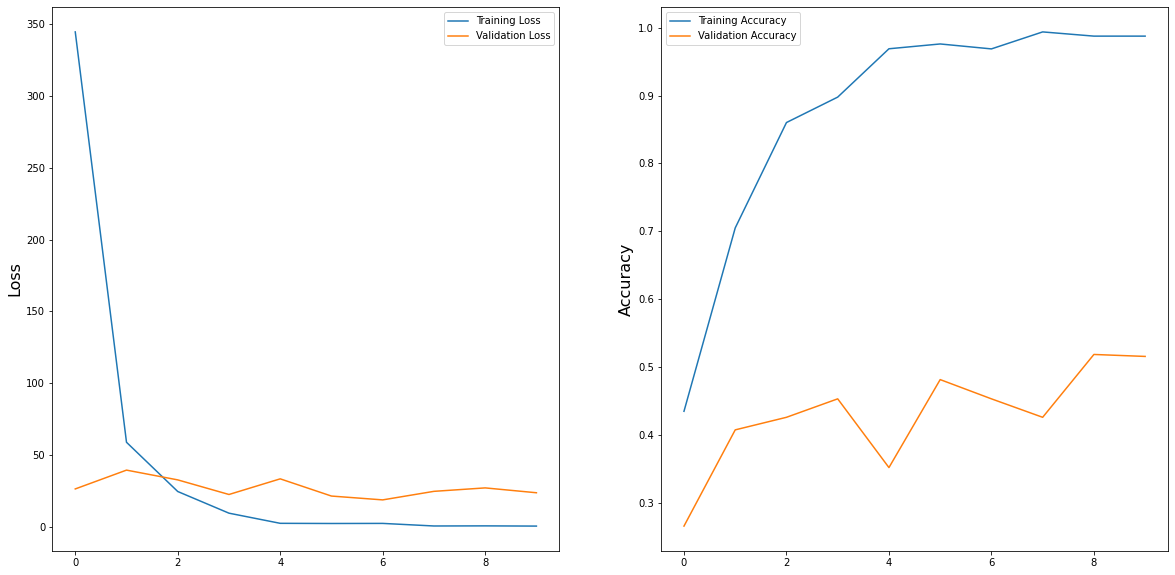

In [6]:
#PLotting the Loss and Acuuracy

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.ylabel('Loss', fontsize=16)
plt.plot(trained.history['loss'], label='Training Loss')
plt.plot(trained.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(trained.history['accuracy'], label='Training Accuracy')
plt.plot(trained.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [27]:
model.save("trained_model.h5")

In [24]:
#Creating Test generator

image_testgen=ImageDataGenerator(rescale=1/255)
test_generator = image_testgen.flow_from_directory('.', classes=['test'], target_size=(300,300), shuffle=False)

Found 30 images belonging to 1 classes.


In [67]:
#Predicting Test data

predictions=model.predict_generator(generator=test_generator)

In [70]:
#Getting Labels for Prediccted data

pred_class = np.argmax(predictions, axis=1)

class_Index = {v:k for k,v in train_generator.class_indices.items()}
class_Names= [class_Index[k] for k in pred_class]

In [76]:
#Creating dataframe 

filenames = test_generator.filenames
result = pd.DataFrame({"Filename":filenames, "Predictions":class_Names})

In [73]:
print(result)

                                             Filename Predictions
0                                       test/1051.png  category 2
1                                       test/1052.png  category 2
2                                       test/4043.png  category 2
3                                       test/4050.png  category 2
4                                       test/4051.png  category 2
5                                       test/4052.png  category 2
6                                       test/6052.png  category 2
7                                       test/6053.png  category 2
8                                       test/C052.png  category 4
9                                       test/C053.png  category 4
10  test/Test_original_1051.png_271f7fb1-f0ab-4ca7...  category 2
11  test/Test_original_1052.png_22a82512-5b1f-4072...  category 1
12  test/Test_original_1052.png_b95bc311-bae0-48a7...  category 2
13  test/Test_original_4043.png_615f9058-5c5c-4430...  category 3
14  test/T

In [79]:
result.to_csv("Predicted_Images.csv", index=False)